# Energy Use 2

Analysing household energy use

Notes:

  - Updated to use the latest data from Octopus (not 'historical' and 'current' data as per the v1 script).
  - Expects a file called data/consumption.csv

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt# Import a scoring metric to compare methods

from datetime import timedelta, datetime

## Read Data

Consumption data downloaded from octopus.
 
Also add a cost column. Current prices are:
 - £0.075 from 00:30 - 04:30
 - £0.3882 all other times
 
TODO
 - [ ] Automate collection from this page https://octopus.energy/dashboard/new/accounts/A-ADD72A6B/consumption/home
 

In [2]:
# A lookup with energy prices in half-hourly time slots
price_lookup = [0.3882] + [0.075] * 8 + [0.3882] * 39

def calc_tarrif(row, price_lookup = price_lookup, cost=False):
    """Given a row of data, use the date (row index), energy use and price lookup
    to calculate the actual cost of energy (if cost=True) or the tarrif (if cost=False)."""
    assert len(price_lookup) == 48, f"Price lookup should have 48 items, not: {len(price_lookup)}"
    date = row.name # Stupidly the index is referenced using 'name' in pandas
    energy = row.energy
    # Find the tarrif for this half hourly slot. Multiply decimal hour by 2
    price_index = int( (date.hour + (date.minute / 60) ) * 2 )
    #print(date, price_index, ( date.hour + (date.minute / 60) ) * 2, price_lookup[price_index])
    tarrif = price_lookup[price_index]
    if cost:
        return tarrif * energy
    else:
        return tarrif

def read_data(filename):
    """Process to read and clean data is the same for historical and latest datasets"""
    raw_data = pd.read_csv(os.path.join("data", filename))
    
    # Drop whitespace
    raw_data[' Start'] = raw_data[' Start'].apply(lambda x: x.strip())
    raw_data[' End'] = raw_data[' End'].apply(lambda x: x.strip())

    raw_data['energy'] = raw_data['Consumption (kWh)'] # Better column label

    # Create date objects
    # Do it properly, but the time offset is really annoying!
    #raw_data['StartDate'] = pd.to_datetime(raw_data[' Start'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    #raw_data['EndDate'] =  pd.to_datetime(raw_data[' End'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    # Ignore the time offset by splitting on the '+'
    raw_data['StartDate'] = raw_data[' Start'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )
    raw_data['EndDate']     = raw_data[' End'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )

    # Index is the start point for 30 minute interval
    #raw_data['Date'] = raw_data['StartDate']
    #raw_data = raw_data.set_index('Date')
    raw_data.index = pd.DatetimeIndex(raw_data.StartDate)
    raw_data.index.name = "Date"

    # Now just take the columns that we want
    raw_data = raw_data.loc[:,['energy']]
    
    # Add tarrif and cost columns 
    raw_data['tarrif'] = raw_data.apply(calc_tarrif, axis=1, cost=False)
    raw_data['cost'] = raw_data.apply(calc_tarrif, axis=1, cost=True)

    # Make some useful ones
    #df['Day'] = df.index.map(lambda x:x.day) # (had to do it this way before I had the DateTimeIndex set up properly)
    raw_data['day'] = raw_data.index.day
    raw_data['month'] = raw_data.index.month
    raw_data['year'] = raw_data.index.year
    raw_data['dayofyear'] = raw_data.index.dayofyear
    # Hour as a decimal
    #raw_data['hour'] = raw_data.index.map(lambda x:x.hour) + raw_data.index.map(lambda x:x.minute) / 60
    raw_data['hour'] =  raw_data.index.hour + (raw_data.index.minute / 60)
    # Season (thanks https://stackoverflow.com/questions/44124436/python-datetime-to-season)
    #[x%12 // 3 + 1 for x in range(13)]
    raw_data['season'] = raw_data.index.month%12 // 3 + 1
    return raw_data

# Read the data
df = read_data("consumption.csv")

In [31]:
print(df.columns)
df

Index(['energy', 'tarrif', 'cost', 'day', 'month', 'year', 'dayofyear', 'hour',
       'season'],
      dtype='object')


,energy,tarrif,cost,day,month,year,dayofyear,hour,season
Date,,,,,,,,,
2023-02-01 00:00:00,1.232,0.3882,0.478262,1,2,2023,32,0.0,1
2023-02-01 00:30:00,1.364,0.0750,0.102300,1,2,2023,32,0.5,1
2023-02-01 01:00:00,0.706,0.0750,0.052950,1,2,2023,32,1.0,1
2023-02-01 01:30:00,0.773,0.0750,0.057975,1,2,2023,32,1.5,1
2023-02-01 02:00:00,0.539,0.0750,0.040425,1,2,2023,32,2.0,1
...,...,...,...,...,...,...,...,...,...
2024-08-12 22:30:00,0.142,0.3882,0.055124,12,8,2024,225,22.5,3
2024-08-12 23:00:00,0.080,0.3882,0.031056,12,8,2024,225,23.0,3
2024-08-12 23:30:00,0.085,0.3882,0.032997,12,8,2024,225,23.5,3


Sanity checks

## Sanity check plots

Plot to check the data look sensible

Daily monthly totals

<Axes: title={'center': 'Daily Energy Use'}, xlabel='Date'>

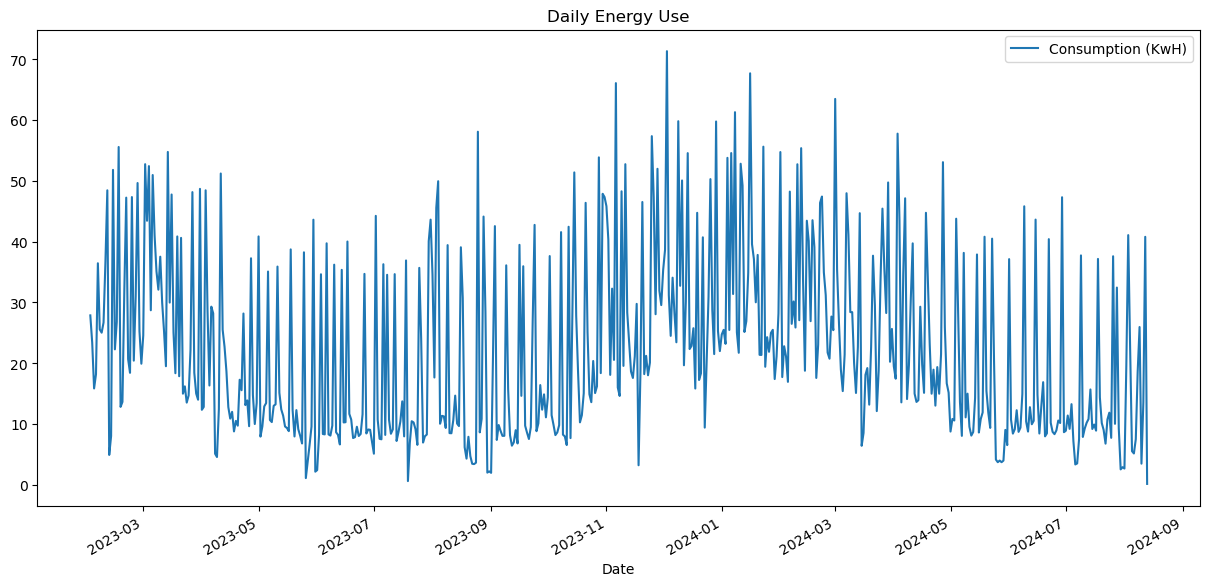

In [5]:
df.groupby(df.index.floor('D'))['energy'].sum().plot(
      figsize=(15, 7), title=f"Daily Energy Use", legend=True, label="Consumption (KwH)")

Monthly totals

<Axes: title={'center': 'Weekly Energy Use'}, xlabel='Date'>

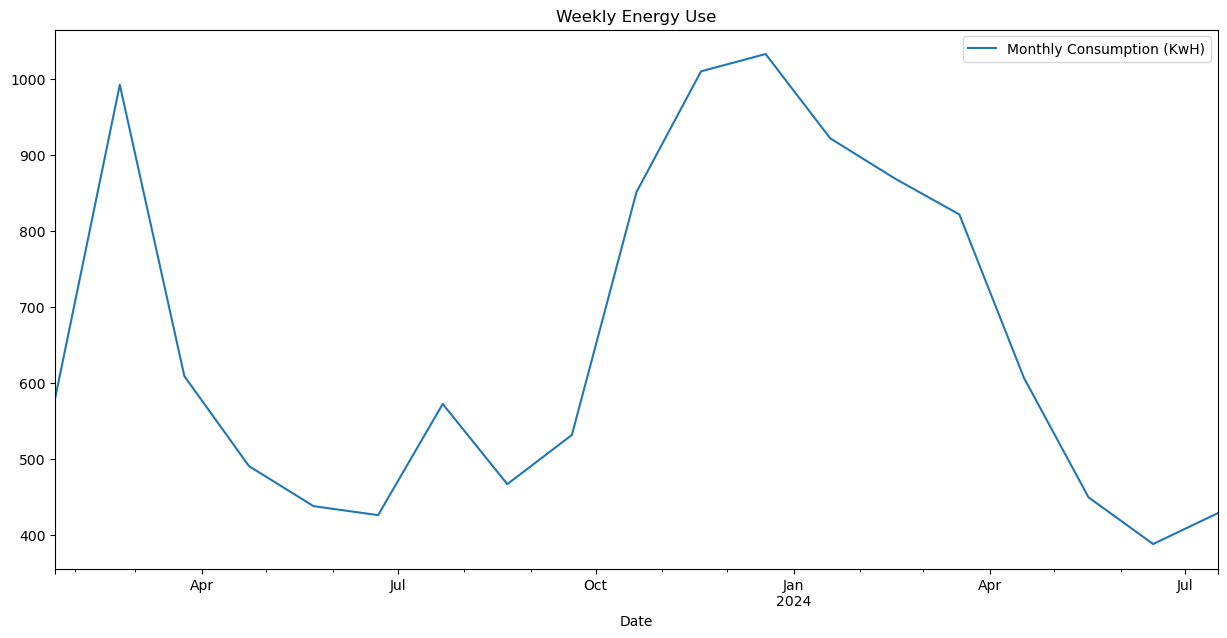

In [26]:
#floor(30D) gives 30 days; approx 1 month
df.groupby(df.index.floor('30D'))['energy'].sum().plot(
        figsize=(15, 7), title=f"Weekly Energy Use", legend=True, label="Monthly Consumption (KwH)")

One week in May, including tarrif

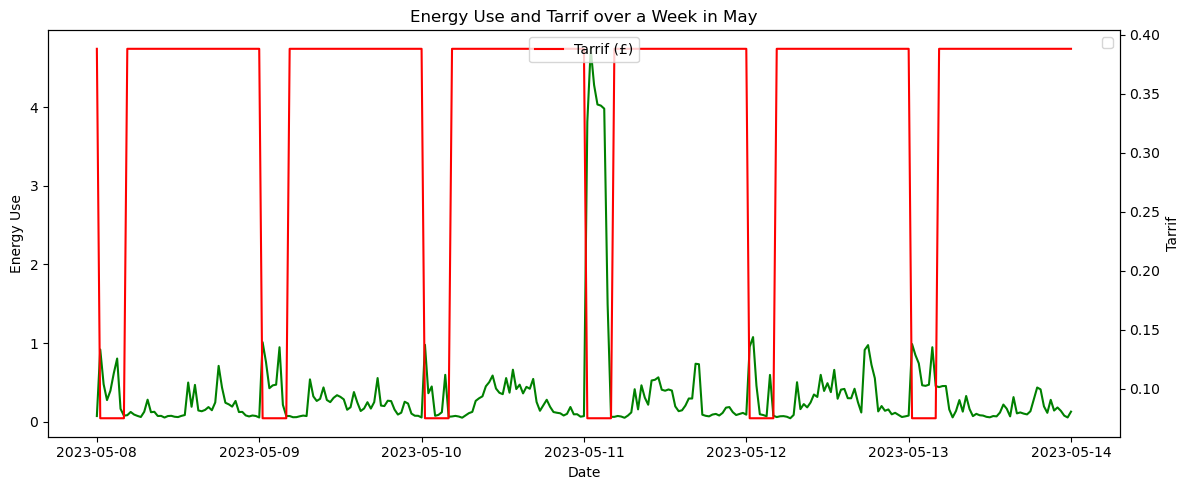

In [7]:
temp = df.loc[datetime.fromisoformat("2023-05-08"):datetime.fromisoformat("2023-05-14"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

#ax.set_xticks(gdp['date'].dt.date)
#ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
#ax.yaxis.grid(color='lightgray', linestyle='dashed')

plt.tight_layout()
plt.show()
#temp.plot(figsize=(15, 7), title="Energy over one week in may (for example)", legend=True, label="energy");
#hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
#         'energy'].plot(figsize=(15, 7), title="Energy over one week in may (for example)");



Another short week in Dec (mostly to check daylight saving hasn't wrecked things, and to check the latest data)

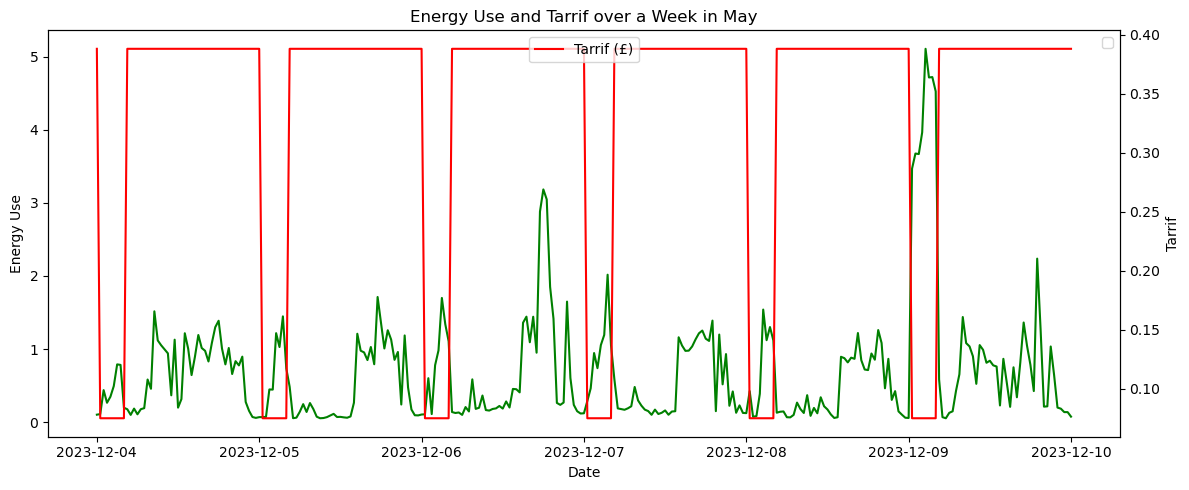

In [8]:
temp = df.loc[datetime.fromisoformat("2023-12-04"):datetime.fromisoformat("2023-12-10"),]


fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

## How much energy is used during the day and overnight?


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


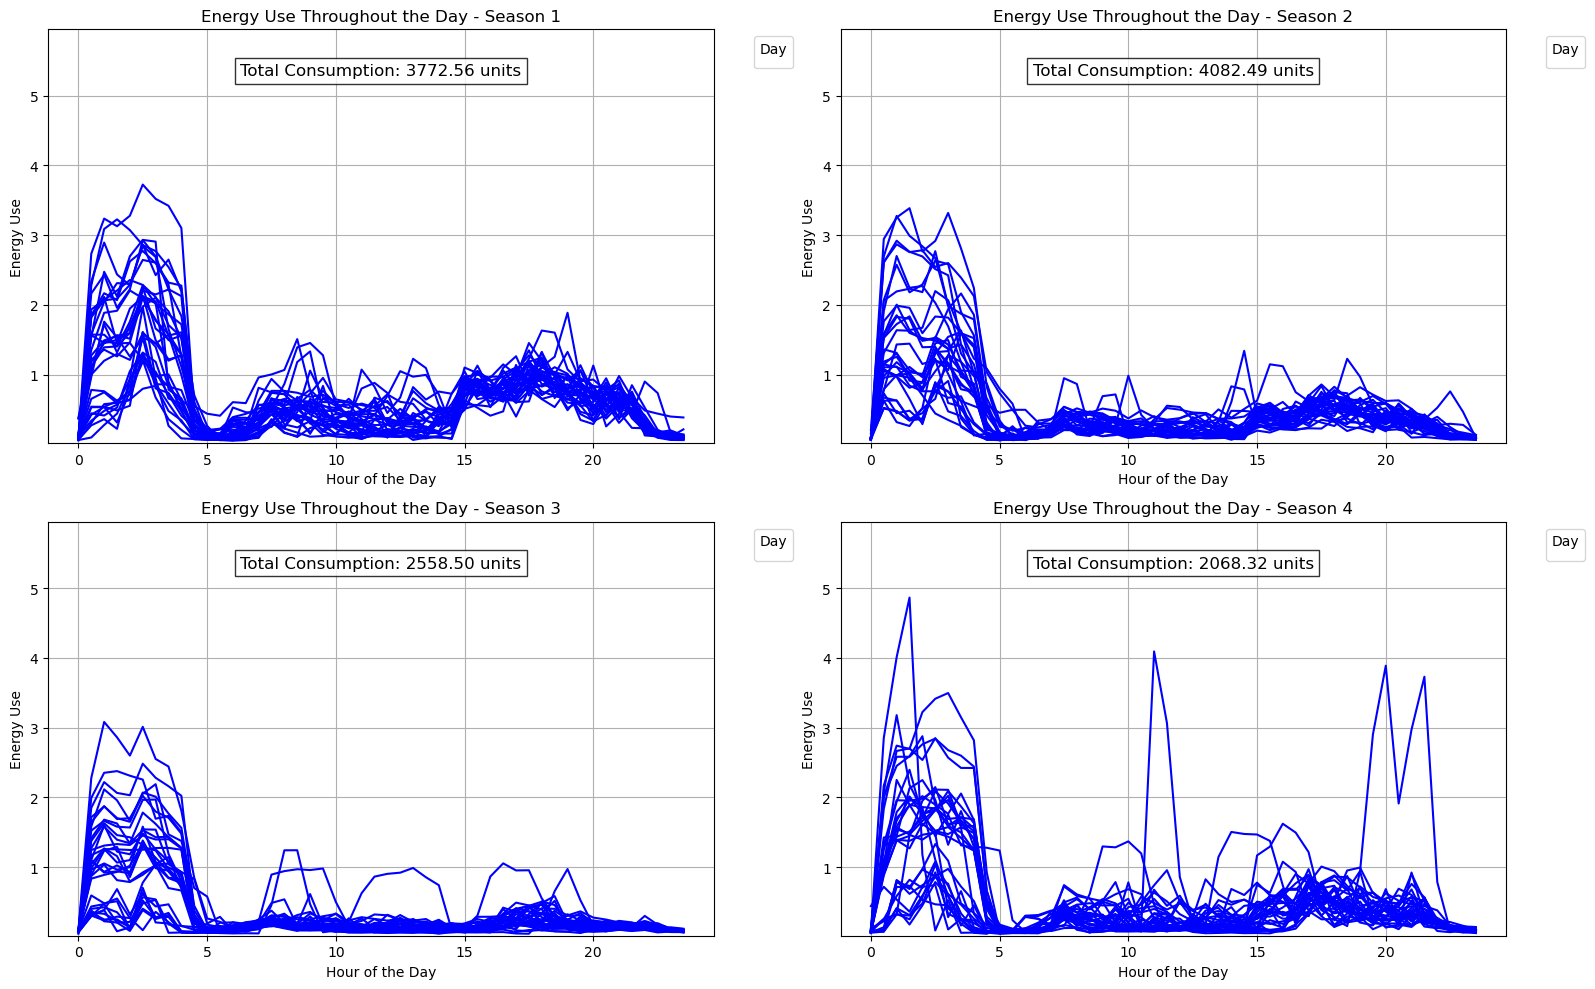

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Get the list of seasons
seasons = df['season'].unique()

# Determine the y-axis limits based on the overall data range
ymin = df['energy'].min()
ymax = df['energy'].max()

# Iterate over each season and create a subplot
for i, season in enumerate(seasons):
    ax = axes[i]  # Get the corresponding subplot

    df_season = df[df['season'] == season]

    # Group by day and hour to get the average energy use for each 30-minute period in each day
    daily_energy = df_season.groupby(['day', 'hour'])['energy'].mean().unstack(level=0)

    # Calculate the total consumption for the current season
    total_consumption = df_season['energy'].sum()

    # Plot a line for each day in the current season
    for day in daily_energy.columns:
        ax.plot(daily_energy.index, daily_energy[day], color="blue", alpha=1.0)

    # Set the y-axis limits based on the overall data range
    ax.set_ylim(ymin, ymax)

    # Display the total consumption as text on the plot
    ax.text(0.5, 0.9, f'Total Consumption: {total_consumption:.2f} units',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Set the title and labels for each subplot
    ax.set_title(f'Energy Use Throughout the Day - Season {season}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Energy Use')
    ax.legend(title='Day', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

In [13]:
df.season.unique()

array([1, 2, 3, 4], dtype=int32)

## Is the cheap overnight tarrif better in winter?

Look at two weeks in winter and estimate whether an overnight tarrif would have been better than a normal one (because when we're running the heat pump it uses a lot of electricity during the day).

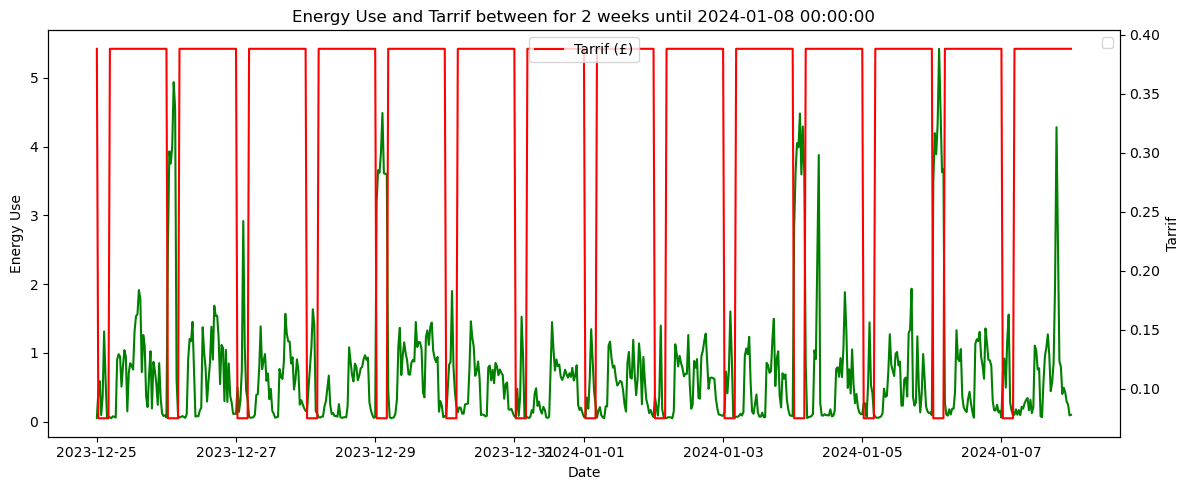

In [8]:
# Cut 2 weeks and plot use and (existing) tarrif

date_now = datetime(2024,1,8,0,0)  # 8th Jan
df_two_weeks = df.loc[date_now-timedelta(weeks=2):date_now]

# Plot 

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title(f'Energy Use and Tarrif between for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(df_two_weeks['energy'], color='green')

ax2.plot(df_two_weeks['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Total cost (actual) and then hypothetical (if on standard tarrif)

In [9]:
# Calculated the cost previously, so can just sum that column
actual_cost_total = df_two_weeks.cost.sum()

# Sanity check (this is the formula used to estimate hypothetical cost in the next chunk)
temp = df_two_weeks.apply(calc_tarrif, axis=1, price_lookup=price_lookup, cost=True)
assert actual_cost_total == temp.sum(), f"Should be equal: {actual_cost_total}, {temp.sum()}" 

print(f"Current (actual) cost over that period is £{round(actual_cost_total)}.")

Current (actual) cost over that period is £134.


In [10]:
# New cost asuming on standard tarrif.

# Hypothetical tarrif is 33p all day
hypothetical_price_lookup = [0.33] * 48 

# Calculate that cost
hypothetical_cost = df_two_weeks.apply(calc_tarrif, axis=1,
                                       price_lookup=hypothetical_price_lookup, cost=True)
df_two_weeks = df_two_weeks.assign(hypothetical_cost=hypothetical_cost)

hypothetical_cost_total = df_two_weeks.hypothetical_cost.sum()
print(f"Hypothetical cost over that period is £{round(hypothetical_cost_total)}.")

Hypothetical cost over that period is £158.


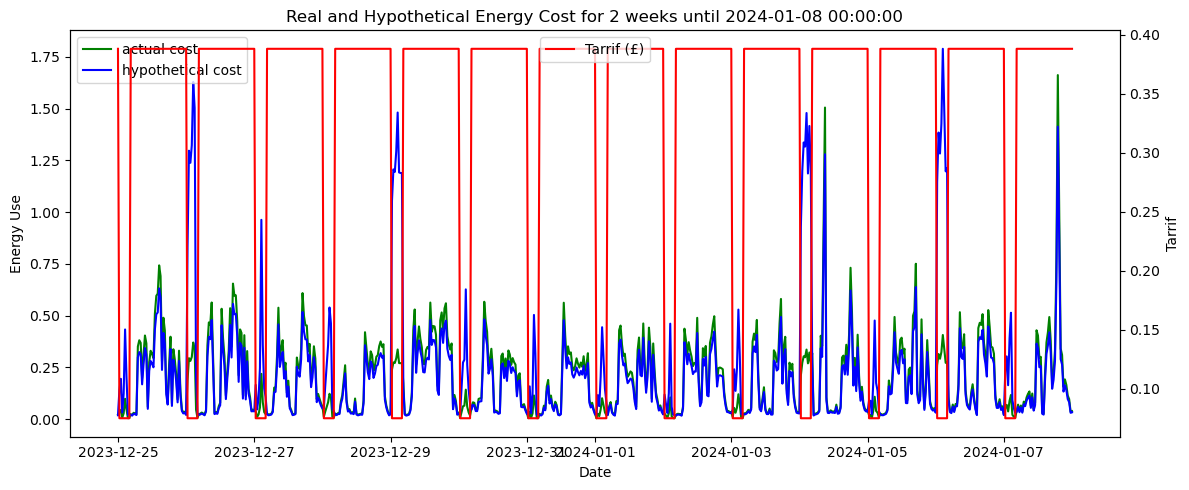

In [11]:
# Plot 

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title(f'Real and Hypothetical Energy Cost for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.plot(df_two_weeks['cost'], color='green', label="actual cost")
ax.plot(df_two_weeks['hypothetical_cost'], color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

ax2.plot(df_two_weeks['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Look at that cumulatively

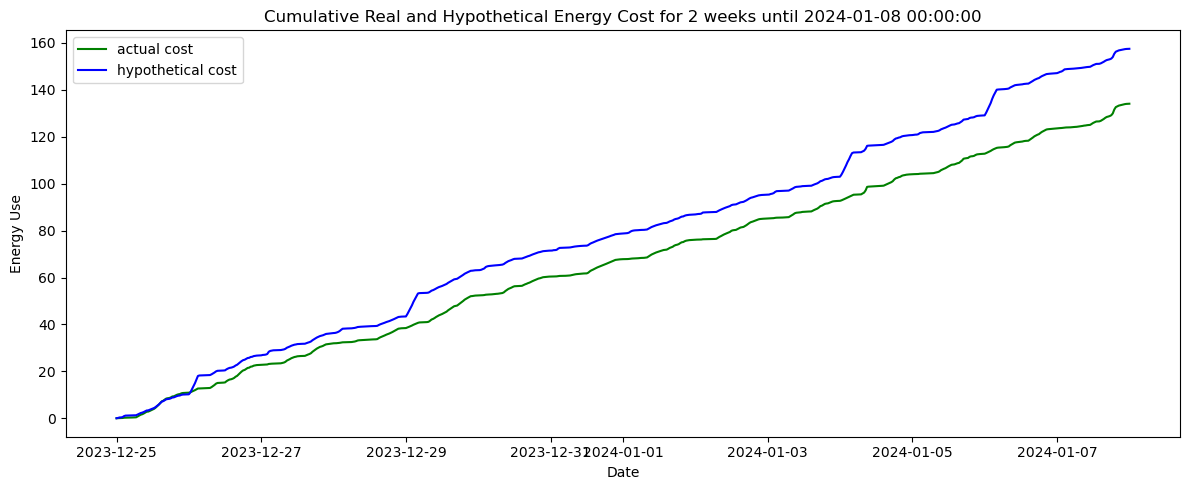

In [12]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title(f'Cumulative Real and Hypothetical Energy Cost for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.plot(df_two_weeks['cost'].cumsum(), color='green', label="actual cost")
ax.plot(df_two_weeks['hypothetical_cost'].cumsum(), color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Is the cheap overnight tarrif better over the whole year?

In [34]:
actual_cost_total = df.cost.sum()
hypothetical_price_lookup = [0.33] * 48
hypothetical_cost = df.apply(calc_tarrif, axis=1, price_lookup=hypothetical_price_lookup, cost=True)
df = df.assign(hypothetical_cost=hypothetical_cost)

hypothetical_cost_total = df.hypothetical_cost.sum()
print(f"Costs (actual / hypothetical) over that period are £{round(actual_cost_total)} / £{round(hypothetical_cost_total)}.")

Costs (actual / hypothetical) over that period are £3034 / £4119.


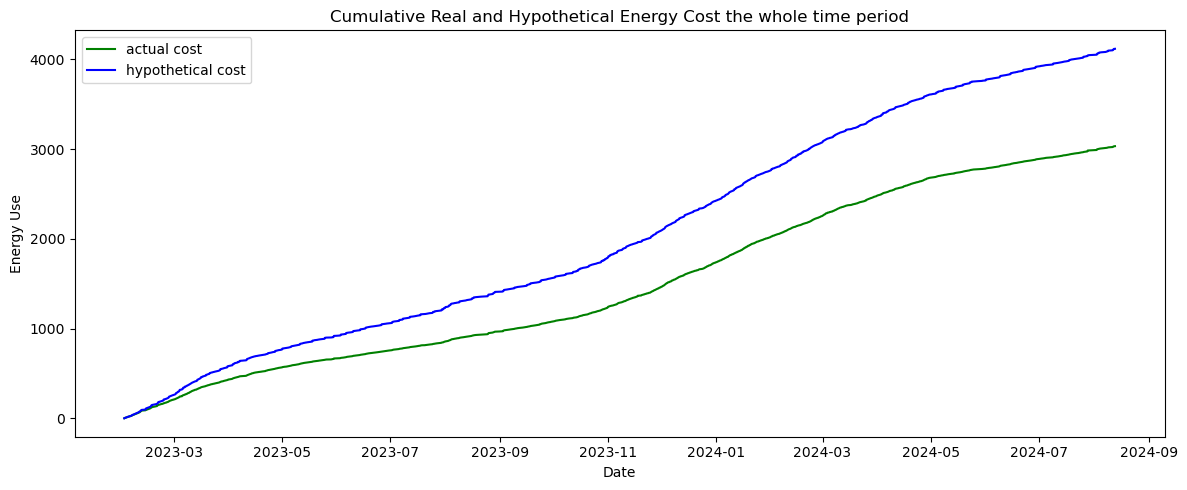

In [36]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title(f'Cumulative Real and Hypothetical Energy Cost the whole time period')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.plot(df['cost'].cumsum(), color='green', label="actual cost")
ax.plot(df['hypothetical_cost'].cumsum(), color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## How much will I save by installing solar panals?

In [ ]:
# XXXX HERE

## Create Averages

Want to estimate new costs after installing heat pump. Need to create some benchmarks. Average use for different days (e.g. weekday in winter, weekend in summer, etc...)